# Notebook goal

The goal of this notebook is to show how to glue multiple small images (from 32x32 images from CIFAR10) together to create a recreate an image. For the sake of simplicity, the width and height of the image that we want to recreate are multiples of 32.

In [1]:
%matplotlib inline
import PIL
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.metrics import pairwise_distances

import torchvision.datasets as datasets

# Data loading

First we load the CIFAR10 data into `numpy` arrays using the `torchvision` library.

In [2]:
cifar_train = datasets.CIFAR10(
    root = '../data',
    train = True,
    download = True,
    transform = None
)
cifar_test = datasets.CIFAR10(
    root = '../data',
    train = False,
    download = True,
    transform = None
)
cat_decoder = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


Then we build a dictionary that list for each of the 10 categories of CIFAR10 the corresponding images.

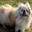

In [3]:
imgs_by_cat = defaultdict(list)

for img, cat in cifar_train + cifar_test:
    imgs_by_cat[cat_decoder[cat]].append(img)

imgs_by_cat['dog'][1]

We then load the image that we want to recreate.

(1024, 1024, 3)


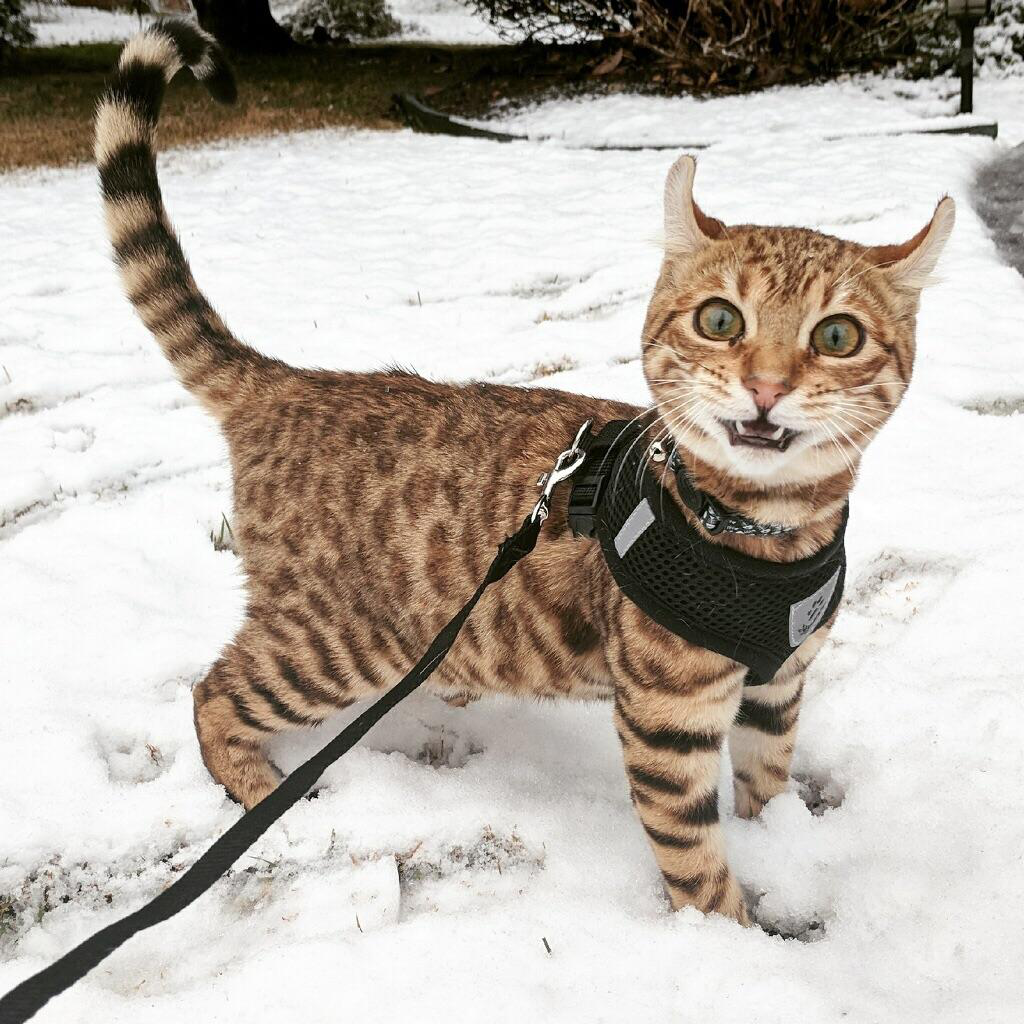

In [4]:
target_img = PIL.Image.open('../data/raw/cat_snow.jpg')
targ_img = np.array(target_img)
print(targ_img.shape)
target_img

Now let's try to convert a CIFAR10 picture into a numpy array and look at its shape.

In [5]:
np.array(imgs_by_cat['dog'][1]).shape

(32, 32, 3)

# Image slicing

Let's also explore how we are going to crop images using numpy multidimensional slicing.

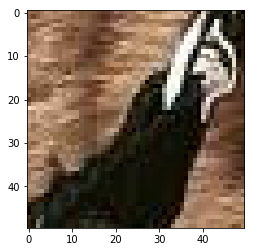

In [6]:
plt.imshow(targ_img[500:550, 500:550])

Now let's write some code to see how we are going to slice an image into sections. 

The goal is to cut a `32x32x3` image into blocks of `4x4` pixels. The output should then be a numpy array of shape `[8,8,4,4,3]` i.e. `[block_x, block_y, block_pixel_x, block_pixel_y, rgb]`

In [7]:
img = np.array(imgs_by_cat['cat'][0])

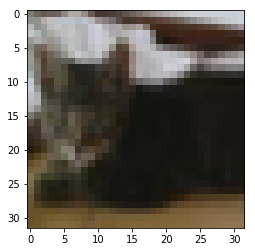

In [8]:
plt.imshow(img)

In [9]:
def slice_image(img, size):
    # result will contain a list of rows slices
    result = []
    for i in range(img.shape[0] // size):
        # As we are starting a new row, we append an empty list to result
        result.append([]) 
        for j in range(img.shape[1] // size):
            img_slice = img[
                i * size : (i + 1) * size, # slicing the x coordinates of the image
                j * size : (j + 1) * size  # slicing the y coordinates of the image
            ] 
            # We append the slice to the current row
            result[-1].append(img_slice)

    return np.array(result)

res = slice_image(img, 4)
print(res.shape)

(8, 8, 4, 4, 3)


There is probably a cleaner way to do this in pure Numpy fashion but I haven't found it. 

# Mean RGB components

## Target image

Our first simple method will consist in finding the CIFAR10 image whose mean `RGB` components is the closest for each block of the target image. Let's slice the image and compute the mean `RGB` value for each block.

In [10]:
big_img_slices = slice_image(targ_img, 32)
big_img_slices.shape

(32, 32, 32, 32, 3)

In [11]:
big_img_block_rgb = big_img_slices.reshape(32, 32, -1, 3).mean(axis = -2)
big_img_block_rgb.shape

(32, 32, 3)

Let's print these mean RGB values for the top left `3x3` blocks (each block is `32x32` pixels).

In [12]:
big_img_block_rgb[:3, :3]

array([[[ 63.58984375,  64.73632812,  52.81445312],
        [155.46289062, 153.78320312, 149.72851562],
        [162.1484375 , 160.06054688, 155.77441406]],

       [[ 33.11328125,  32.89453125,  19.95117188],
        [ 90.890625  ,  90.83203125,  77.59277344],
        [ 93.82226562,  94.83300781,  76.13183594]],

       [[ 29.69726562,  27.7734375 ,  10.76660156],
        [ 29.38476562,  26.91601562,   8.60449219],
        [ 30.421875  ,  27.64257812,   8.24023438]]])

This result makes sense as the very top right is very bright and the area slightly below is a lot darker.

## CIFAR10 mean components

Now that we have the mean components for each block of the target image, lets compute the mean RGB value for each image of the CIFAR10 dataset.

First, we select a category and compute the statistics for each image in this category. For now let's only work with cat images because kawaii.

In [13]:
cifar_imgs = np.stack([np.array(img) for img in imgs_by_cat['dog']])
cifar_imgs.shape

(6000, 32, 32, 3)

In [14]:
cifar_mean_rgb = cifar_imgs.reshape(cifar_imgs.shape[0], -1, 3).mean(axis = -2)
cifar_mean_rgb.shape

(6000, 3)

# Best block replacement

In [15]:
print(big_img_block_rgb.shape)
print(cifar_mean_rgb.shape)

(32, 32, 3)
(6000, 3)


Now that we have our two numpy arrays, we want to look for the best replacement for each block of the target in the CIFAR10 dataset. To quantify *best*, we are going to use the euclidean distance.

In [16]:
pairwise_euc_dist = pairwise_distances(
    big_img_block_rgb.reshape(-1, 3), # we have to reshape the target image 
                                      #blocks array into a [x, 3] array
    cifar_mean_rgb,
    metric = 'euclidean'
)
pairwise_euc_dist = pairwise_euc_dist.reshape(*big_img_block_rgb.shape[:2], -1)
pairwise_euc_dist.shape

(32, 32, 6000)

The `pairwise_euc_dist` now contains for each block an array of distances to each CIFAR10 image.

Now let's find the best fit using this array. The best image can be found by finding the index of the minimum distance for each block.

In [17]:
best_block_replacement = pairwise_euc_dist.argmin(axis = -1)
print(best_block_replacement[:3, :3])
print(best_block_replacement.shape)

[[1071 4587 1807]
 [5793 5860 1602]
 [5793 5793 5793]]
(32, 32)


# Gluing result

In [18]:
imgs_to_glue = cifar_imgs[best_block_replacement]
imgs_to_glue.shape

(32, 32, 32, 32, 3)

In [19]:
glued_img = np.transpose(
    imgs_to_glue, 
    (0, 2, 1, 3, 4)
).reshape(*targ_img.shape)
glued_img.shape

(1024, 1024, 3)

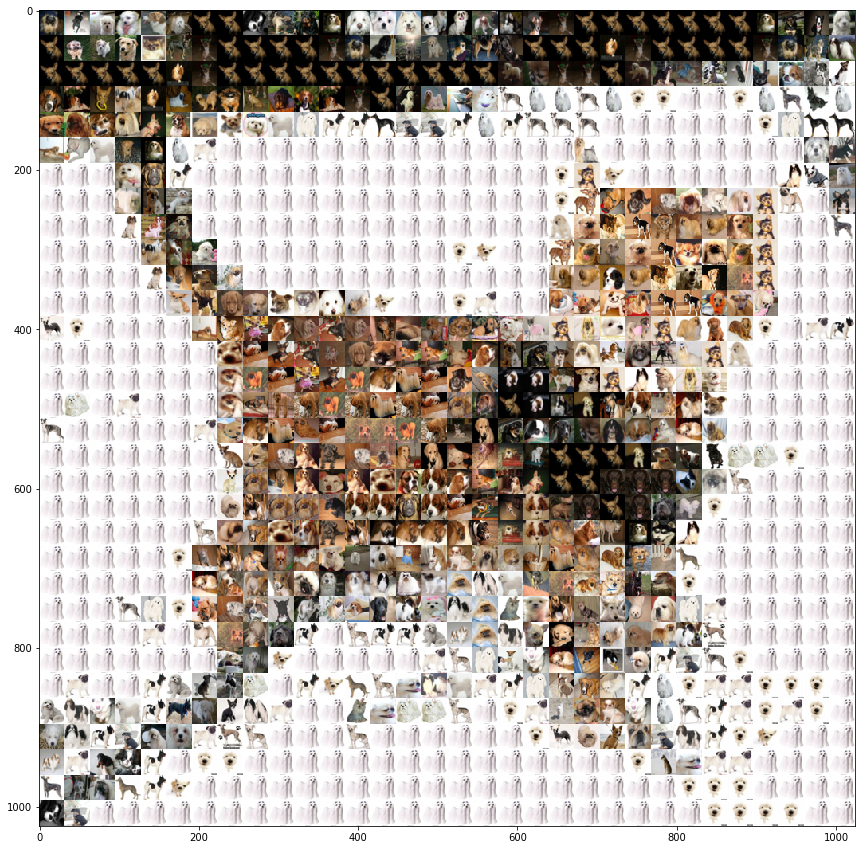

In [20]:
plt.figure(figsize = (15, 15))
plt.imshow(glued_img)